# Using the Configuration File API

This tutorial introduces the Configuration File API and how it can be used to generate and export custom GridLab-D and OpenDSS versions of the power system models stored in the Blazegraph database.

__Learning Objectives:__

At the end of the tutorial, the user should be able to use the Configuration File API to

* Generate a custom GridLab-D simulation file
* Export a GridLab-D base GLM file
* Export a list of GridLab-D measurements
* Generate a customer OpenDSS power system model
* Export a list of OpenDSS location coordinates
* Create and export the model Y-Bus Matrix

## Getting Started

Before running any of the sample routines in this tutorial, it is first necessary to start the GridAPPS-D Platform and establish a connection to this notebook so that we can start passing calls to the API.

_Open the Ubuntu terminal and start the GridAPPS-D Platform if it is not running already:_

`cd gridappsd-docker`

~/gridappsd-docker$ `./run.sh -t develop`

_Once containers are running,_

gridappsd@[container]:/gridappsd$ `./run-gridappsd.sh`

In [ ]:
# Establish connection to GridAPPS-D Platform:
from gridappsd import GridAPPSD
gapps = GridAPPSD("('localhost', 61613)", username='system', password='manager')
model_mrid = "_49AD8E07-3BF9-A4E2-CB8F-C3722F837B62" # IEEE 13 Node used for all example queries

---

## Table of Contents

* [1. Introduction to the Configuration File API](#1.-Introduction-to-the-Configuration-File-API)


* [2. Using the Configuration File API](#2.-Using-the-Configuration-File-API)
    * [2.1. Specifying the Topic](#2.1.-Specifying-the-Topic)
    * [2.2. Structure of a Query Message](#2.2.-Structure-of-a-Query-Message)
    * [2.3. Specifying the configurationType](#2.3.-Specifying-the-configurationType)
    
    
* [3. Querying for Feeder Model Info](#3.-Querying-for-Feeder-Model-Info)
    * [3.1. Query for all GridLab-D Files](#3.1.-Query-for-all-GridLab-D-Files)
    * [3.2. Query for GridLab-D Base GLM File](#3.2.-Query-for-GridLab-D-Base-GLM-File)
    * [3.3. Query for GridLab-D Symbols File](#3.3.-Query-for-GridLab-D-Symbols-File)
    * [3.4. Query for GridLab-D Measurement Types](#3.4.-Query-for-GridLab-D-Measurement-Types)
    
    
* [4. Querying for CIM Dictionary Files](#4.-Querying-for-CIM-Dictionary-Files)
    * [4.1. Query for CIM Model Dictionary](#4.1.-Query-for-Model-Dictionary)
    * [4.2. Query for CIM Feeder Index](#4.2.-Query-for-CIM-Feeder-Index)


* [5. Querying for OpenDSS Configuration Files](#5.-Querying-for-OpenDSS-Configuration-Files)
    * [5.1. Query for all OpenDSS Files](#5.1.-Query-for-all-OpenDSS-Files)
    * [5.2. Query for OpenDSS Base File](#5.2.-Query-for-OpenDSS-Base-File)
    * [5.3. Query for OpenDSS Coordinate File](#5.3.-Query-for-OpenDSS-Coordinate-File)
    * [5.4.-Query for Y-Bus Matrix](#5.4.-Query-for-Y-Bus-Matrix)

## 1. Introduction to the Configuration File API


The Configuration File API is used to generate power system models that can be solved in GridLab-D or OpenDSS based on the original CIM XML model. The load profile and ZIP parameters can be modified from the nominal values prior to model creation and export.

In the Application Components diagram (explained in detail with sample code in [GridAPPS-D Application Structure](2.4--Lesson-2.4--GridAPPS-D-Application-Structure.ipynb)), the Configuration File API is used for configuring parallel simulations and exporting the power system model.

![04_config_sim_export.png](images/3.4/04_config_sim_export.png)

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system configuration in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail below.

The application then passes the query through the Configuration File API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Configuration Manager.

__GridAPPS-D Platform responds to Application query__

The Configuration Manager obtains the CIM XML file for the desired power system model and then converts it to the desired output format with all of the requested changes to the model. The Configuration File API then returns the desired information back to the application as a JSON message (for Y-Bus or partial models) or export the files to the directory specified in the 

---

## 2. API Syntax Overview

### 2.1. API Communication Channel

All queries passed to the PowerGrid Models API need to use the correct communication channel, which is obtained using the [GridAPPS-D Topics library](3.1--Lesson-3.1--API-Communication-Channels.ipynb). 

The PowerGrid Model API uses a `/queue/` channel to pull power system model info from the the Blazegraph Database. The base static string used is `goss.gridappsd.process.request.config`, which can be called using the `.CONFIG` method from the topics library.

When developing in python, it is recommended to use the `.CONFIG` method. When using the STOMP client in GridAPPS-D VIZ, it is necessary to use the base static string.

In [ ]:
from gridappsd import topics as t
topic = t.CONFIG

[Return to Top](#Table-of-Contents)

### 2.2. Structure of a Query Message

Queries passed to Configuration File API are formatted as python dictionaries or equivalent JSON scripts wrapped as a python string. 

The accepted set of key-value pairs for the Configuration File API query message is

```
message = {
    "configurationType": "INSERT QUERY HERE",
    "parameters": {
        "key1": "value1",
        "key2": "value2"}        
}
```

The components of the message are as follows:

* `"configurationType":` -- Specifies the type of configuration file requested.


* `"parameters":` -- Specifies any specific power system model parameters. Values depend on the particular configurationType.


The usage of each of these message components are explained in detail with code block examples below. 

__Important__: Be sure to pay attention to placement of commas ( __,__ ) at the end of each JSON line. Commas are placed at the end of each line _except_ the last line. Incorrect comma placement will result in a JsonSyntaxException. 

All of the queries are passed to the Configuration API using the `.get_response(topic, message)` method for the GridAPPS-D platform connection variable.

[Return to Top](#Table-of-Contents)

### 2.3. Specifying the `configurationType`

Below are the possible `configurationType` key-value pairs that are used to specify the type of each query. Executable code block examples are provided for each of the requests in the subsections below.

The first group of _configurationType_ key-value pairs are for queries for information related to the GridLab-D GLM files and settings:


* `"configurationType": "GridLab-D All"` -- [Query for all GridLab-D files](#3.1.-Query-for-all-GridLab-D-Files)


* `"configurationType": "GridLab-D Base GLM"` -- [Query for GridLab-D base GLM file](#3.2.-Query-for-GridLab-D-Base-GLM-File)


* `"configurationType": "GridLab-D Symbols"` -- [Query for GridLab-D symbols file](#3.3.-Query-for-GridLab-D-Symbols-File)


* `"configurationType": "GridLab-D Simulation Output"` -- [Query for available measurement types](#3.4.-Query-for-GridLab-D-Measurement-Types)



The second group of _configurationType_ are for queries for CIM dictionary and feeder index files:

* `"configurationType": "CIM Dictionary"` -- [Query for python dictionary of CIM XML model](#4.1.-Query-for-Model-Dictionary)


* `"configurationType": "CIM Feeder Index"` -- [Query for python dictionary of model mRIDs](#4.2.-Query-for-CIM-Feeder-Index)




The third group of _configurationType_ key-value pairs are for queries for OpenDSS model files


* `"configurationType": "DSS All"` -- [Query for all OpenDSS model files](#5.1.-Query-for-all-OpenDSS-Files)


* `"configurationType": "DSS Base"` -- [Query for OpenDSS version of power system model](#5.2.-Query-for-OpenDSS-Base-File)


* `"configurationType": "DSS Coordinate"` -- [Query for list of OpenDSS XY coordinates](#5.3.-Query-for-OpenDSS-Coordinate-File)


* `"configurationType": "YBus Export"` -- [Export Y-Bus matrix from OpenDSS](#5.4.-Query-for-Y-Bus-Matrix)

[Return to Top](#Table-of-Contents)

---

## 3. Querying for GridLab-D Configuration Files

This section outlines the details of key-value pairs for the possible queries associated with each value of the `queryMeasurement` key listed above.

### 3.1. Query for all GridLab-D Files

This API call generates all the GLM files necessary to solve the power system model in GridLab-D. The query returns a directory where the set of GLM files are located. 

Configuration File request key-value pair:

* `"configurationType": "GridLab-D All"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                "directory":                          output directory as string ,
                "simulation_name":                    string ,
                "simulation_start_time":              epoch time number ,
                "simulation_duration":                number ,
                "simulation_id":                      number ,
                "simulation_broker_host":             string ,
                "simulation_broker_port":             number ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "i_fraction":                         number ,
                "p_fraction":                         number ,
                "z_fraction":                         number ,
                "load_scaling_factor":                number ,
                "schedule_name":                      string ,
                "solver_method":                      string }
                
```

The numeric values for the key-value pairs associated with `parameters` can be written as number or as strings. The key-value pairs can be specified in any order.

__Example: Export IEEE 13 node model with constant current loads to GLM files :__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "GridLAB-D All",
    "parameters": {
        "directory": "/tmp/gridlabdsimulation/",
        "model_id": model_mrid,
        "simulation_id": "12345678",
        "simulation_name": "mysimulation",
        "simulation_start_time": "1518958800",
        "simulation_duration": "60",
        "simulation_broker_host": "localhost",
        "simulation_broker_port": "61616",
        "schedule_name": "ieeezipload",
        "load_scaling_factor": "1.0",
        "z_fraction": "0.0",
        "i_fraction": "1.0",
        "p_fraction": "0.0",
        "solver_method": "NR" }
}

gapps.get_response(topic, message, timeout = 120)

__Note:__ The output directory is inside the GridAPPS-D Docker Container, not in your Ubuntu or Windows environment. To access the files, it is necessary to change directories to those inside the docker container.

Open a new Ubuntu terminal and run:
* `docker exec -it gridappsd-docker_gridappsd_1 bash`
* `cd /tmp/gridlabdsimulation`
* `ls -l`

To copy the files to your regular directory, use the `docker cp` command. For help using docker, see [Docker Shortcuts](1.6--Lesson-1.6--Docker-Shortcuts.ipynb) on working with Docker containers.

![2_7_config_file_docker_directory.png](images/3.4/config_file_docker_directory.png)

[Return to Top](#Table-of-Contents)

---

## 3.2. Query for GridLab-D Base GLM File

This API call generates a single GLM file that contains the entire power system model that can be solved in GridLab-D. The query returns the entire model GLM file wrapped in a python dictionary.

Configuration File request key-value pair:

* `"configurationType": "GridLab-D Base GLM"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "i_fraction":                         number ,
                "p_fraction":                         number ,
                "z_fraction":                         number ,
                "load_scaling_factor":                number ,
                "schedule_name":                      string }
                
```

The numeric values for the key-value pairs associated with `parameters` can be written as number or as strings. The key-value pairs can be specified in any order.

__Example 1: Create GLM base file using nominal load values:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "GridLAB-D Base GLM",
    "parameters": {"model_id": model_mrid}
}

gapps.get_response(topic, message, timeout = 60)

__Example 2: Create GLM base file using all constant current loads and hourly load curve:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "GridLAB-D Base GLM",
    "parameters": {
        "model_id": model_mrid,
        "load_scaling_factor": "1.0",
        "z_fraction": 0.0,
        "i_fraction": 1.0,
        "p_fraction": "0.0",
        "schedule_name": "ieeezipload"}
}

gapps.get_response(topic, message, timeout = 60)

[Return to Top](#Table-of-Contents)

---

## 3.3. Query for GridLab-D Symbols File

This API call generates a file with all the XY coordinates used by GridLab-D when running a simulation.

Configuration File request key-value pair:

* `"configurationType": "GridLab-D Symbols"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "GridLAB-D Symbols",
    "parameters": { "model_id": model_mrid }
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

## 3.4. Query for GridLab-D Measurement Types

This API call returns a list of device names and types of available measurement in the GridLab-D format (__not__ CIM classes or measurement mRIDs)

Configuration File request key-value pair:

* `"configurationType": "GridLab-D Simulation Output"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "GridLAB-D Simulation Output",
    "parameters":{"model_id": model_mrid}
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

## 4. Querying for CIM Dictionary Files

### 4.1. Query for Model Dictionary

This API generates a python dictionary which maps the CIM mRIDs of objects in the power system model to names of model objects used in other simulators.

Configuration File request key-value pair:

* `"configurationType": "CIM Dictionary"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "CIM Dictionary",
    "parameters":{"model_id": "_AAE94E4A-2465-6F5E-37B1-3E72183A4E44"}
}

gapps.get_response(topic, message, timeout = 30)

[Return to Top](#Table-of-Contents)

---

### 4.2. Query for CIM Feeder Index 

This API call returns a python dictionary of the available feeders in the Blazegraph database of power system models.

Configuration File request key-value pair:

* `"configurationType": "CIM Feeder Index"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "CIM Feeder Index",
    "parameters":{"model_id": model_mrid}
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

## 5. Querying for OpenDSS Configuration Files

### 5.1. Query for all OpenDSS Files

This API call generates all the OpenDSS files necessary to solve the power system model in OpenDSS. The query returns a directory where the set of DSS files are located. 

Configuration File request key-value pair:

* `"configurationType": "DSS All"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                "directory":                          desired output directory as string ,
                "simulation_name":                     string ,
                "simulation_start_time":              epoch time number ,
                "simulation_duration":                number ,
                "simulation_id":                      number ,
                "simulation_broker_host":             string ,
                "simulation_broker_port":             number ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "i_fraction":                         number ,
                "p_fraction":                         number ,
                "z_fraction":                         number ,
                "load_scaling_factor":                number ,
                "schedule_name":                      string ,
                "solver_method":                      string }
                
```

The numeric values for the key-value pairs associated with `parameters` can be written as number or as strings. The key-value pairs can be specified in any order.

__Example: Export IEEE 13 node model with constant current loads to DSS files :__



In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS All",
    "parameters": {
        "directory": "/tmp/dsssimulation/",
        "model_id": model_mrid,
        "simulation_id": "12345678",
        "simulation_name": "ieee13",
        "simulation_start_time": "1518958800",
        "simulation_duration": "60",
        "simulation_broker_host": "localhost",
        "simulation_broker_port": "61616",
        "schedule_name": "ieeezipload",
        "load_scaling_factor": "1.0",
        "z_fraction": "0.0",
        "i_fraction": "1.0",
        "p_fraction": "0.0",
        "solver_method": "NR" }
}

gapps.get_response(topic, message)

__Note:__ The output directory is inside the GridAPPS-D Docker Container, not in your Ubuntu or Windows environment. To access the files, it is necessary to change directories to those inside the docker container.

Open a new Ubuntu terminal and run:
* `docker exec -it gridappsd-docker_gridappsd_1 bash`
* `cd /tmp/dssdsimulation`
* `ls -l`

To copy the files to your regular directory, use the `docker cp` command. For help using docker, see [Docker Shortcuts](1.6--Lesson-1.6--Docker-Shortcuts.ipynb) on working with Docker containers.

[Return to Top](#Table-of-Contents)

---

### 5.2. Query for OpenDSS Base File

This API call generates a single DSS file that contains the entire power system model that can be solved in OpenDSS. The query returns the entire model DSS file wrapped in a python dictionary.

Configuration File request key-value pair:

* `"configurationType": "DSS Base"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "i_fraction":                         number ,
                "p_fraction":                         number ,
                "z_fraction":                         number ,
                "load_scaling_factor":                number ,
                "schedule_name":                      string }
                
```

The numeric values for the key-value pairs associated with `parameters` can be written as number or as strings. The key-value pairs can be specified in any order.

__Example 1: Create GLM base file using nominal load values:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS Base",
    "parameters": {"model_id": model_mrid}
}

gapps.get_response(topic, message)

__Example 2: Create GLM base file using all constant current loads and hourly load curve:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS Base",
    "parameters": {
        "model_id": model_mrid,
        "load_scaling_factor": "1.0",
        "z_fraction": 0.0,
        "i_fraction": 1.0,
        "p_fraction": "0.0",
        "schedule_name": "ieeezipload"}
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

### 5.3. Query for OpenDSS Coordinate File

This API call generates a file with all the XY coordinates used by OpenDSS when plotting the feeder.

Configuration File request key-value pair:

* `"configurationType": "DSS Coordinate"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OPTIONAL KEYS                  OPTIONAL VALUES
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS Coordinate",
    "parameters": {"model_id": model_mrid}
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

### 5.4. Query for Y-Bus Matrix

This API call generates a Y-Bus matrix from __either__ the model mRID or the simulation id.

__Note:__ The GridAPPS-D platform currently does not have an in-built topology processor, so the Y-Bus matrix is NOT updated during the simulation to reflect switching actions or transformer tap changes that happen in real time.  

Configuration File request key-value pair:

* `"configurationType": "YBus Export"`

The `parameters` key has a set of required values as well as some optional values:

```
"parameters": {     REQUIRED KEYS                   REQUIRED VALUES
                "model_id":                           mRID as string ,
                    OR
                "simulation_id":                      number }
                
```
The key-value pairs can be specified in any order.

__Example 1: Request Y-Bus for IEEE 13 node model using model mRID:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "YBus Export",
    "parameters": {"model_id": model_mrid}
}

gapps.get_response(topic, message)

__Example 2: Request Y-Bus for IEEE 13 node model with all loads set as constant current using model mRID:__

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "YBus Export",
    "parameters": {
        "model_id": "_C1C3E687-6FFD-C753-582B-632A27E28507",
        "load_scaling_factor": "2.0",
        "schedule_name": "ieeezipload",
        "z_fraction": "0.4",
        "i_fraction": "0.3",
        "p_fraction": "0.3" }
}

gapps.get_response(topic, message)

__Example 3: Obtain Y-Bus from simulation_id:__

In [ ]:
viz_simulation_id = "paste id here"

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType":"YBus Export",
    "parameters":{"simulation_id": viz_simulation_id}
}

gapps.get_response(topic, message)

[Return to Top](#Table-of-Contents)

---

[![Previous.png](images/Previous.png)](3.3--Lesson-3.3--Using-the-PowerGrid-Models-API.ipynb)

[![Quiz.png](images/Quiz.png)](3.4Q--Quiz-for-Lesson-3.4.ipynb)

[![Next.png](images/Next.png)](3.5--Lesson-3.5--Creating-Running-Simulation-API.ipynb)

[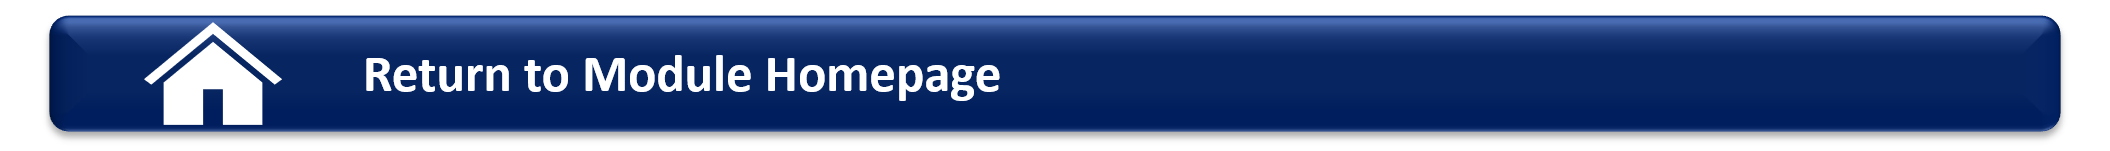](3.0--Module-3--GridAPPS-D-API-Usage.ipynb)

---

![GridAPPS-D_narrow.png](images/GridAPPS-D_narrow.png)